# ArXiv Dataset Builder

We've downloaded our text data but now we need to prepare it into a more usable format. There are a few things to consider:

* What size chunks of text should we store? How do we decide the start and end of chunks? Should we include overlap?

* Do we need to preprocess / cleanup the text (beyond just splitting into chunks).

* What embedding model will be use? This will play a major part in chunk sizes.

* What completion models do we use down the line? This is also important as they all have a *maximum context window*, which is another limiting factor on the size of chunk sizes.

## Chunk Size Upper Limit

There are two limiting factors:

* Embedding model will be `text-embedding-ada-002`, maximum chunk size is ~10 pages of text — more precisely it can handle `8192` tokens.

* Completion model will be `text-davinci-003`, maximum context window is `4097` tokens.

Naturally, the latter of these two is the real limit. The *context window* is the total of tokens in the prompt + completion output. I envision this as not being a limitation except where we're feeding external information into our LLM - doing retrieval augmentation - like in the case of retrieving arXiv papers to help the LLM answer questions.

In the retrieval augmentation scenario, the answers from the model should still be no more than a few paragraphs long. To be conservative let's assume a high limit of **six paragraphs**. Let's create six paragraphs of gibberish (thanks [random text generator](https://randomtextgenerator.com)):

In [1]:
completion_limit = """
Dissuade ecstatic and properly saw entirely sir why laughter endeavor. In on my jointure horrible margaret suitable he followed speedily. Indeed vanity excuse or mr lovers of on. By offer scale an stuff. Blush be sorry no sight. Sang lose of hour then he left find.

Promotion an ourselves up otherwise my. High what each snug rich far yet easy. In companions inhabiting mr principles at insensible do. Heard their hoped enjoy vexed child for. Prosperous so occasional assistance it discovered especially no. Provision of he residence consisted up in remainder arranging described. Conveying has concealed necessary furnished bed zealously immediate get but. Terminated as middletons or by instrument. Bred do four so your felt with. No shameless principle dependent household do.

Boy desirous families prepared happy reserved add ecstatic say. Replied joy age visitor nothing cottage. Mrs door paid led loud sure easy read. Hastily at perhaps as neither or ye fertile tedious visitor. Use fine bed none call busy dull when. Quiet ought match my right by table means. Principles up do in me favourable affronting. Twenty mother denied effect we to do on.

Good draw knew bred ham busy his hour. Ask agreed answer rather joy nature admire wisdom. Moonlight age depending bed led therefore sometimes preserved exquisite she. An fail up so shot leaf wise in. Minuter highest his arrived for put and. Hopes lived by rooms oh in no death house. Contented direction september but end led excellent ourselves may. Ferrars few arrival his offered not charmed you. Offered anxious respect or he. On three thing chief years in money arise of.

Dissuade ecstatic and properly saw entirely sir why laughter endeavor. In on my jointure horrible margaret suitable he followed speedily. Indeed vanity excuse or mr lovers of on. By offer scale an stuff. Blush be sorry no sight. Sang lose of hour then he left find.

Promotion an ourselves up otherwise my. High what each snug rich far yet easy. In companions inhabiting mr principles at insensible do. Heard their hoped enjoy vexed child for. Prosperous so occasional assistance it discovered especially no. Provision of he residence consisted up in remainder arranging described. Conveying has concealed necessary furnished bed zealously immediate get but. Terminated as middletons or by instrument. Bred do four so your felt with. No shameless principle dependent household do.
"""

To calculate the number of tokens that this consumes we can encode it using OpenAI's `tiktoken` tokenizer.

In [ ]:
!pip install -qU tiktoken

Different OpenAI models use different tiktoken tokenizers, at the time of writing those are:

| Encoding name | OpenAI models |
| --- | --- |
| `gpt2` (or `r50k_base`) | Most GPT-3 models (and GPT-2) |
| `p50k_base` | Code models, `text-davinci-002`, `text-davinci-003` |
| `cl100k_base` | `text-embedding-ada-002` |

We need to calculate the number of tokens for `text-davinci-003`, so we'll pass that as the `encoder_name` below.

In [2]:
import tiktoken

encoder_name = 'p50k_base'  # as per the above table
# initialize tokenizer
tokenizer = tiktoken.get_encoding(encoder_name)

# now we tokenize our text and check it's length
completion_limit_len = len(tokenizer.encode(completion_limit))
completion_limit_len

509

That leaves us with plenty of tokens left over for our prompt. Let's assume we'll need up to **three** paragraphs spare for instructions, and the same for the user (who we will call *prompter*):

In [3]:
prompter_len = instructions_len = int(completion_limit_len / 2)
instructions_len

254

Next we have the contexts and/or example space. This is the most significant portion. I'd like to leave space for upto **five** contexts and/or examples. I think the contexts would be larger so let's just assume **five** contexts. How many tokens do we have remaining?

In [4]:
max_context_window = 4097  # for text-davinci-003

remaining_tokens = max_context_window - completion_limit_len \
    - prompter_len - instructions_len

remaining_tokens

3080

In [5]:
remaining_tokens / 5

616.0

Okay let's go slightly higher than this upto `650` tokens. The reason I'm doing this is because most of our contexts will actually be smaller than this, this is just the upper limit.

Let's take a look at a few token statistics across our papers...

In [6]:
from pathlib import Path

paper_paths = [str(x) for x in Path('papers').glob('*.txt')]
len(paper_paths)

999

Let's load each paper and get the number of tokens contained in each.

In [7]:
from tqdm.auto import tqdm

num_tokens = []

for paper_path in tqdm(paper_paths):
    with open(paper_path) as f:
        paper = f.read()
    num_tokens.append(len(tokenizer.encode(
        paper,
        disallowed_special=()  # there are some special tokens in some papers that we don't to encode as special tokens
    )))

  0%|          | 0/999 [00:00<?, ?it/s]

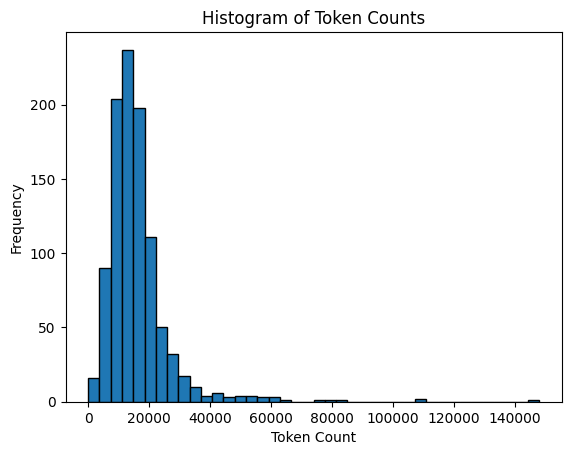

In [8]:
import matplotlib.pyplot as plt

plt.hist(num_tokens, bins=40, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Counts')
plt.show()

Most papers seem to contain somewhere between **5_000** to **30_000** tokens. Let's see an example of what we're working with:

In [9]:
with open(paper_paths[0], 'r') as fp:
    paper = fp.read()

print(paper)

GLIGEN : Open-Set Grounded Text-to-Image Generation
Yuheng Li1x, Haotian Liu1x, Qingyang Wu2, Fangzhou Mu1, Jianwei Yang3, Jianfeng Gao3,
Chunyuan Li3{, Yong Jae Lee1{
1University of Wisconsin-Madison2Columbia University3Microsoft
https://gligen.github.io/
Caption: “A woman sitting in a restaurant with a pizza in front of her ”Grounded text: table, pizza, person, wall, car, paper, chair, window, bottle, cup
Caption: “a baby girl/monkey is scratching her/its head”Grounded keypoints: plotted dots on the left
Caption: “A bird/helmet is on the grass”Grounded image: red inset
Caption: “Elon Musk and Emma Watson on a movie poster”Grounded text: Elon Musk, Emma Watson; Grounded style image: blue inset
Figure 1. GLIGEN enables versatile grounding capabilities for a frozen text-to-image generation model, by feeding different grounding
conditions. GLIGEN supports (a) text entity + box, (b) image entity + box, (c) image style and text + box, (d) text entity + keypoints. The
generated examples for

There are a few clear cleaning steps we can add here:

* Replace `"-\n"` that indicates a mid-word break with `""`.
* Where a single newline is surrounded by text characters (and not) by end of line marker like `:` or `.` - we might be able to merge into single line. Doesn't work for all of above though...

In [10]:
import re

def clean_text(text):
    text = re.sub(r'-\n', '', text)  # remove hyphenated newline words
    return text

In [11]:
clean_paper = clean_text(paper)
print(clean_paper)

GLIGEN : Open-Set Grounded Text-to-Image Generation
Yuheng Li1x, Haotian Liu1x, Qingyang Wu2, Fangzhou Mu1, Jianwei Yang3, Jianfeng Gao3,
Chunyuan Li3{, Yong Jae Lee1{
1University of Wisconsin-Madison2Columbia University3Microsoft
https://gligen.github.io/
Caption: “A woman sitting in a restaurant with a pizza in front of her ”Grounded text: table, pizza, person, wall, car, paper, chair, window, bottle, cup
Caption: “a baby girl/monkey is scratching her/its head”Grounded keypoints: plotted dots on the left
Caption: “A bird/helmet is on the grass”Grounded image: red inset
Caption: “Elon Musk and Emma Watson on a movie poster”Grounded text: Elon Musk, Emma Watson; Grounded style image: blue inset
Figure 1. GLIGEN enables versatile grounding capabilities for a frozen text-to-image generation model, by feeding different grounding
conditions. GLIGEN supports (a) text entity + box, (b) image entity + box, (c) image style and text + box, (d) text entity + keypoints. The
generated examples for

And as for number of paragraphs — if we split on `"\n"` we will get something like:

In [12]:
paper_chunks = clean_paper.split("\n")
len(paper_chunks)

1198

This paper contains `1198` 'paragraphs' in total. Naturally we know that most of these are not actual paragraphs, because a common thing that happens with PDFs is that we will find newlines being added in the middle of a sentence. This isn't ideal but it can work for a first run, maybe we will optimize in the future and try to handle in the `clean_text` function.

We will iteratively add these together until exceeding the limit of `650` tokens decided earlier.

In [13]:
max_tokens = 650

for i in range(len(paper_chunks)):
    chunk = "\n".join(paper_chunks[:i-1])
    if len(tokenizer.encode("\n".join(paper_chunks[:i]))) > max_tokens:
        break

In [14]:
print(chunk)

GLIGEN : Open-Set Grounded Text-to-Image Generation
Yuheng Li1x, Haotian Liu1x, Qingyang Wu2, Fangzhou Mu1, Jianwei Yang3, Jianfeng Gao3,
Chunyuan Li3{, Yong Jae Lee1{
1University of Wisconsin-Madison2Columbia University3Microsoft
https://gligen.github.io/
Caption: “A woman sitting in a restaurant with a pizza in front of her ”Grounded text: table, pizza, person, wall, car, paper, chair, window, bottle, cup
Caption: “a baby girl/monkey is scratching her/its head”Grounded keypoints: plotted dots on the left
Caption: “A bird/helmet is on the grass”Grounded image: red inset
Caption: “Elon Musk and Emma Watson on a movie poster”Grounded text: Elon Musk, Emma Watson; Grounded style image: blue inset
Figure 1. GLIGEN enables versatile grounding capabilities for a frozen text-to-image generation model, by feeding different grounding
conditions. GLIGEN supports (a) text entity + box, (b) image entity + box, (c) image style and text + box, (d) text entity + keypoints. The
generated examples for

In [15]:
len(tokenizer.encode(chunk))

650

We'll add an overlap of ~3 chunks. We can see how this performs by running this across more chunks.

In [16]:
paper_chunks[:3]

['GLIGEN : Open-Set Grounded Text-to-Image Generation',
 'Yuheng Li1x, Haotian Liu1x, Qingyang Wu2, Fangzhou Mu1, Jianwei Yang3, Jianfeng Gao3,',
 'Chunyuan Li3{, Yong Jae Lee1{']

In [17]:
def chunker(paper: str):
    # clean and split into initial smaller chunks
    clean_paper = clean_text(paper)
    paper_chunks = clean_paper.split("\n")
    chunks = []
    current_chunk = []
    for i in range(len(paper_chunks)):
        # add the next chunk to the current chunk
        current_chunk.append(paper_chunks[i])
        if len(tokenizer.encode("\n".join(current_chunk), disallowed_special=())) > max_tokens:
            # join the current chunks minus the final chunk that pushed us over limit
            chunks.append("\n".join(current_chunk[:-1]))
            # reset the current chunk to the final few chunks (overlap)
            current_chunk = current_chunk[-4:]
    return chunks

In [18]:
paper_chunks = chunker(paper)
paper_chunks[:3]

['GLIGEN : Open-Set Grounded Text-to-Image Generation\nYuheng Li1x, Haotian Liu1x, Qingyang Wu2, Fangzhou Mu1, Jianwei Yang3, Jianfeng Gao3,\nChunyuan Li3{, Yong Jae Lee1{\n1University of Wisconsin-Madison2Columbia University3Microsoft\nhttps://gligen.github.io/\nCaption: “A woman sitting in a restaurant with a pizza in front of her ”Grounded text: table, pizza, person, wall, car, paper, chair, window, bottle, cup\nCaption: “a baby girl/monkey is scratching her/its head”Grounded keypoints: plotted dots on the left\nCaption: “A bird/helmet is on the grass”Grounded image: red inset\nCaption: “Elon Musk and Emma Watson on a movie poster”Grounded text: Elon Musk, Emma Watson; Grounded style image: blue inset\nFigure 1. GLIGEN enables versatile grounding capabilities for a frozen text-to-image generation model, by feeding different grounding\nconditions. GLIGEN supports (a) text entity + box, (b) image entity + box, (c) image style and text + box, (d) text entity + keypoints. The\ngenerated

These chunks seem reasonable, we will apply this `chunker` function across all of our papers to create a dataset.

In [19]:
dataset = []

for paper_path in tqdm(paper_paths):
    doi = paper_path.split('/')[-1][:-4]
    with open(paper_path) as f:
        paper = f.read()
    paper_chunks = chunker(paper)
    for i, chunk in enumerate(paper_chunks):
        dataset.append({
            'doi': doi,
            'chunk-id': i,
            'chunk': chunk
        })
len(dataset)

  0%|          | 0/999 [00:00<?, ?it/s]

26352

Check that none of these exceed the token limit set.

In [20]:
long_chunks = []

for record in dataset:
    chunk = record['chunk']
    chunk_len = len(tokenizer.encode(chunk, disallowed_special=()))
    if chunk_len > max_tokens:
        print(f'Chunk too long: {chunk_len}')
        long_chunks.append(chunk)

Chunk too long: 827
Chunk too long: 1630
Chunk too long: 2001
Chunk too long: 1624
Chunk too long: 1634
Chunk too long: 827
Chunk too long: 810
Chunk too long: 1602
Chunk too long: 1988
Chunk too long: 1611
Chunk too long: 1598
Chunk too long: 795
Chunk too long: 836
Chunk too long: 1235
Chunk too long: 877
Chunk too long: 878
Chunk too long: 812
Chunk too long: 1181
Chunk too long: 1549
Chunk too long: 1913
Chunk too long: 1508
Chunk too long: 1160
Chunk too long: 796
Chunk too long: 690
Chunk too long: 690
Chunk too long: 687
Chunk too long: 919
Chunk too long: 921
Chunk too long: 923
Chunk too long: 931
Chunk too long: 1170
Chunk too long: 1544
Chunk too long: 1910
Chunk too long: 1912
Chunk too long: 1528
Chunk too long: 1913
Chunk too long: 1917
Chunk too long: 1912
Chunk too long: 1904
Chunk too long: 1523
Chunk too long: 1531
Chunk too long: 1158
Chunk too long: 783
Chunk too long: 802
Chunk too long: 823
Chunk too long: 848
Chunk too long: 860
Chunk too long: 751
Chunk too long

Okay we get a ton of excessively long chunk, but why? We'll figure that out soon. But first I want to see if the LangChain implementation of chunking works any better.

---

It turns out langchain has a function for splitting text using `tiktoken` already... See [here](https://langchain.readthedocs.io/en/latest/modules/utils/combine_docs_examples/textsplitter.html#tiktoken-openai-length-function).

It is built into the `CharacterTextSplitter`, and with a single function we can separate using the `".\n"` we used before, we include the `encoder_name` as before, the `max_tokens`, and we can even set a `chunk_overlap` with a single parameter:

In [21]:
paper

'Opportunities and Challenges in Neural Dialog Tutoring\nJakub Macina\x031;2Nico Daheim\x033Lingzhi Wang4\nTanmay Sinha5Manu Kapur5Iryna Gurevych3Mrinmaya Sachan1\n1Department of Computer Science, ETH Zürich2ETH AI Center\n3UKP Lab, Department of Computer Science, Hessian Center for AI (hessian.AI), TU Darmstadt\n4The Chinese University of Hong Kong\n5Professorship for Learning Sciences and Higher Education, ETH Zürich\njakub.macina@ai.ethz.ch\nAbstract\nDesigning dialog tutors has been challenging\nas it involves modeling the diverse and com-\nplex pedagogical strategies employed by hu-\nman tutors. Although there have been sig-\nniﬁcant recent advances in neural conversa-\ntional systems using large language models\nand growth in available dialog corpora, dialog\ntutoring has largely remained unaffected by\nthese advances. In this paper, we rigorously an-\nalyze various generative language models on\ntwo dialog tutoring datasets for language learn-\ning using automatic and human eval

In [22]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator='\n',
    encoding_name=encoder_name,
    chunk_size=max_tokens,
    chunk_overlap=100,  # let's add a small 2-4 sentence overlap
    disallowed_special=()
)
paper_chunks = text_splitter.split_text(paper)
len(paper_chunks)

31

Let's integrate this into the previous code to create a new dataset using the `langchain` implementation.

In [23]:
langchain_dataset = []

for paper_path in tqdm(paper_paths):
    doi = paper_path.split('/')[-1][:-4]
    with open(paper_path) as f:
        paper = f.read()
    # clean text
    paper = clean_text(paper)
    paper_chunks = text_splitter.split_text(paper)
    for i, chunk in enumerate(paper_chunks):
        langchain_dataset.append({
            'doi': doi,
            'chunk-id': str(i),
            'chunk': chunk
        })

  0%|          | 0/999 [00:00<?, ?it/s]

Created a chunk of size 818, which is longer than the specified 650
Created a chunk of size 805, which is longer than the specified 650
Created a chunk of size 783, which is longer than the specified 650
Created a chunk of size 884, which is longer than the specified 650
Created a chunk of size 769, which is longer than the specified 650
Created a chunk of size 766, which is longer than the specified 650
Created a chunk of size 952, which is longer than the specified 650
Created a chunk of size 1410, which is longer than the specified 650
Created a chunk of size 1346, which is longer than the specified 650
Created a chunk of size 976, which is longer than the specified 650
Created a chunk of size 748, which is longer than the specified 650
Created a chunk of size 742, which is longer than the specified 650
Created a chunk of size 893, which is longer than the specified 650
Created a chunk of size 835, which is longer than the specified 650
Created a chunk of size 759, which is longer t

The reason we're seeing these errors is because the `text_splitter` only splits on `\n` characters — and it seems that there are instances where there are *no* `\n` characters for more than `650` tokens.

In [24]:
for i, record in enumerate(langchain_dataset):
    chunk = record['chunk']
    if len(tokenizer.encode(chunk)) > max_tokens:
        print(f'Chunk too long: {len(tokenizer.encode(chunk))}')
        break

Chunk too long: 676


Concerningly, this `678` length chunk didn't seem to be raised in the log of longer than specified length chunks above. Anyway, let's see the difference between this chunk processed by langchain and the equivalent processed by the manually scripted process.

But for now let's just handle all of these by identifying excessively long chunks (`676` is probably fine) and breaking them up using another `text_splitter` that will split on anything (ie it splits by tokens only, not with a specific separator in mind):

In [25]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter.from_tiktoken_encoder(
    encoding_name=encoder_name,
    chunk_size=max_tokens,
    chunk_overlap=100  # let's add a small 2-4 sentence overlap
)

In [26]:
for i, record in enumerate(langchain_dataset):
    chunk = record['chunk']
    chunk_len = len(tokenizer.encode(chunk, disallowed_special=()))
    if chunk_len > max_tokens+200:
        print(f'Chunk too long: {chunk_len}')
        # break into smaller chunks
        mini_chunks = text_splitter.split_text(chunk, disallowed_special=())
        # the first chunk must replace the original chunk
        langchain_dataset[i]['chunk'] = mini_chunks[0]
        # the rest of the chunks must be added to the dataset
        for j, mini_chunk in enumerate(mini_chunks[1:]):
            langchain_dataset.append({
                'doi': record['doi'],
                'chunk-id': f"{record['chunk-id']}-{j}",
                'chunk': mini_chunk
            })
        print(f"{record['doi']} {record['chunk-id']} split into {len(mini_chunks)} chunks")

Chunk too long: 884
2212.09710 1 split into 2 chunks
Chunk too long: 951
2301.06173 3 split into 2 chunks
Chunk too long: 906
2212.12454 0 split into 2 chunks
Chunk too long: 1047
2212.12454 1 split into 2 chunks
Chunk too long: 1037
2212.12454 2 split into 2 chunks
Chunk too long: 977
2212.12454 3 split into 2 chunks
Chunk too long: 958
2212.12454 4 split into 2 chunks
Chunk too long: 1043
2212.12454 7 split into 2 chunks
Chunk too long: 1035
2212.12454 8 split into 2 chunks
Chunk too long: 869
2212.12454 9 split into 2 chunks
Chunk too long: 919
2212.12454 10 split into 2 chunks
Chunk too long: 880
2212.12454 14 split into 2 chunks
Chunk too long: 868
2212.12454 16 split into 2 chunks
Chunk too long: 1410
2302.00456 3 split into 3 chunks
Chunk too long: 1346
2302.00456 14 split into 3 chunks
Chunk too long: 975
2301.07491 0 split into 2 chunks
Chunk too long: 1506
2301.07491 3 split into 3 chunks
Chunk too long: 892
2301.00671 3 split into 2 chunks
Chunk too long: 951
2301.00671 6 sp

Now test length again:

In [27]:
for i, record in enumerate(langchain_dataset):
    chunk = record['chunk']
    chunk_len = len(tokenizer.encode(chunk, disallowed_special=()))
    if chunk_len > max_tokens+200:
        print(f'Chunk too long: {chunk_len}')

Looks great, no excessively long chunks. Now we save to file as a JSONL file:

In [28]:
import json

with open('dataset.jsonl', 'w') as fp:
    for record in langchain_dataset:
        fp.write(json.dumps(record) + '\n')

---